Author: Marie Laure, marielaure@bayesimpact.org

# IMT Employment Type from API

The IMT dataset provides regional statistics about different jobs. Here we are interested in the employment types distribution. Employment types are categories of contract types (mostly based on contract duration and permanent vs temporary).
Previously, we retrieved IMT data by scraping the IMT website. As an exploratory step, we are interested in the sanity of the API based data and identifying putative additional information provided only by the API.

The dataset can be obtained with the following command, note that it may take some time to download:

docker-compose run --rm data-analysis-prepare make data/imt/employment_type.csv

## Data Sanity

**Loading and General View First let's load the csv file:**

In [1]:
import os
from os import path

import matplotlib
import pandas as pd
import seaborn as _

DATA_FOLDER = os.getenv('DATA_FOLDER')

employment_types = pd.read_csv(path.join(DATA_FOLDER, 'imt/employment_type.csv'), dtype={'AREA_CODE': 'str'})
employment_types.head()

,AREA_CODE,AREA_NAME,AREA_TYPE_CODE,AREA_TYPE_NAME,CONTRACT_TYPE_CODE,CONTRACT_TYPE_NAME,NB_OFFERS,OFFERS_PERCENT,ROME_PROFESSION_CARD_CODE,ROME_PROFESSION_CARD_NAME
0,7327,CASTELSARRASIN,B,Bassin,4,Intérim,3,100.00,I1310,Maintenance mécanique industrielle
1,4203,SARRE-UNION SAVERNE,B,Bassin,3,CDD > 3 mois,12,85.71,K2104,Éducation et surveillance au sein d'établissem...
2,4203,SARRE-UNION SAVERNE,B,Bassin,4,Intérim,7,70.00,H2102,Conduite d'équipement de production alimentaire
3,4204,STRASBOURG,B,Bassin,3,CDD > 3 mois,3,60.00,K1102,Aide aux bénéficiaires d'une mesure de protect...
4,4204,STRASBOURG,B,Bassin,1,CDI,7,50.00,H2202,Conduite d'équipement de fabrication de l'ameu...


Done! So we have access to different area types, contract types for each area and a number and percentage of offers. [Documentation](https://www.emploi-store-dev.fr/portail-developpeur-cms/home/catalogue-des-api/documentation-des-api/api-infotravail-v1/api-infotravail-imt/types-contrats-utilises.html;JSESSIONID_JAHIA=58E556F7FE4784C2498242D3BA5C4F88) defines the number of offers as the number of offers with this contract type for a specific market (a given area and a particular job). Same idea for percentages. Note that data are updated annually.

**How big is this dataset (how many rows)?**

In [2]:
len(employment_types)

417241

Not that bad!

**Any missing value?**

In [3]:
employment_types.isnull().describe()

,AREA_CODE,AREA_NAME,AREA_TYPE_CODE,AREA_TYPE_NAME,CONTRACT_TYPE_CODE,CONTRACT_TYPE_NAME,NB_OFFERS,OFFERS_PERCENT,ROME_PROFESSION_CARD_CODE,ROME_PROFESSION_CARD_NAME
count,417241,417241,417241,417241,417241,417241,417241,417241,417241,417241
unique,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,417241,417241,417241,417241,417241,417241,417241,417241,417241,417241


Nope! Good Job Pôle Emploi!

**How many types of contract do we have?**

In [4]:
employment_types.CONTRACT_TYPE_NAME.unique()

array(['Intérim', 'CDD > 3 mois', 'CDI', 'CDD <= 3 mois', 'Autre'], dtype=object)

The expected types are here. Short-term, long-term, permanent... and even "others".

**How many job groups?**

In [5]:
rome_list = employment_types.ROME_PROFESSION_CARD_CODE.unique()
rome_list.size

531

In [6]:
'L1510' in rome_list

False

Almost... The job group with ROME code L1510 (latest addition to the job groups) is not yet part of this team. Remember that this dataset is updated annually...

How many area types do we have?

In [7]:
employment_types.AREA_TYPE_NAME.unique()

array(['Bassin', 'Département', 'Région', 'France entière'], dtype=object)

We have four different area types. Good.

**Let's see if every region is represented.**

In [8]:
employment_types[employment_types.AREA_TYPE_CODE == 'R'].AREA_CODE.unique().size

18

Yes! In France, in Septempber 2017 there are [13 metropolitan regions and 5 overseas regions](https://en.wikipedia.org/wiki/Regions_of_France#cite_note-INSEE-1).

**Same for the departments! Anyone missing??**

In [9]:
employment_types[employment_types.AREA_TYPE_CODE == 'D'].AREA_CODE.unique().size

103

Hmm. We would expect [101](https://fr.wikipedia.org/wiki/Liste_des_d%C3%A9partements_fran%C3%A7ais).

**Let's see which ones are not expected (but truly welcomed)…**

In [10]:
employment_types[employment_types.AREA_TYPE_CODE == 'D'].AREA_CODE.sort_values().unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '971', '972', '973',
       '974', '976', '977', '978'], dtype=object)

The overseas collectivities of Saint-Barthélémy et Saint-Martin are defined here as departments. So far so good.

**Ok we have regions, departments, "bassin"... But how many areas in total are there?**

In [11]:
len(employment_types.groupby(['AREA_CODE', 'AREA_TYPE_CODE']))

527

OK! So we would expect `527 * 5 * 531 = 1399185` lines. Thus leaving 981944 (~70%) missing lines.

**Why are these lines missing?** Maybe uninformative rows (e.g. rows with zero offers) are missing (we've seen that before...). Let's get a brief description of the number and percentage of offers.

In [12]:
employment_types[['NB_OFFERS', 'OFFERS_PERCENT']].describe()

,NB_OFFERS,OFFERS_PERCENT
count,417241.000000,417241.000000
mean,28.716363,39.683540
std,310.264395,30.839346
min,1.000000,0.010000
25%,1.000000,14.290000
50%,4.000000,33.330000
75%,12.000000,58.340000
max,50854.000000,100.000000


First thing first, there are no row with zero offers. The good news is that no percentage of offers is above 100. I don't know if you feel the same but the maximum number of offers seems crazy to me!

Let's have a closer look at this one.

In [13]:
employment_types[employment_types.NB_OFFERS == 50854]\
    [['AREA_NAME', 'CONTRACT_TYPE_NAME', 'NB_OFFERS', 'OFFERS_PERCENT', 'ROME_PROFESSION_CARD_NAME']]

,AREA_NAME,CONTRACT_TYPE_NAME,NB_OFFERS,OFFERS_PERCENT,ROME_PROFESSION_CARD_NAME
390100,FRANCE ENTIERE,CDI,50854,60.25,Assistance auprès d'enfants


Seems legit. Nothing crazy here... Plenty of permanent position offers in children care on a national scope.

**Maybe we should check that the sum of the percentages are close to 100%?**

In [14]:
def sum_percentages(job_contracts):
    num_contracts = len(job_contracts) 
    sum = 0.0
    for i in range(num_contracts):
        sum += job_contracts.OFFERS_PERCENT.iloc[i]
    if sum < 99.9 or sum > 100.1:
        print('{} {}'.format(job_contracts.ROME_PROFESSION_CARD_NAME, sum))

employment_types.groupby(['AREA_CODE', 'AREA_TYPE_CODE', 'ROME_PROFESSION_CARD_CODE']).apply(sum_percentages);

Great!! Everything is as expected.

## Conclusion

This dataset is super clean.
The most recent job group 'L1510' is not used here.
To be present in the dataset a job has to have at least one offer with a specific employment type in an area. That leads to a lot of missing rows.

## Overview and Comparison with Website Data

The scraped data provide the percentage of offers at the department level for a specific job group. So, the main differences are the availability of other area levels and the raw number of offers. We'll see how consistent this is.

**An additional explanation for the high number of missing rows could be the fact that employment types are super specific for a market (job group x area intersection).**

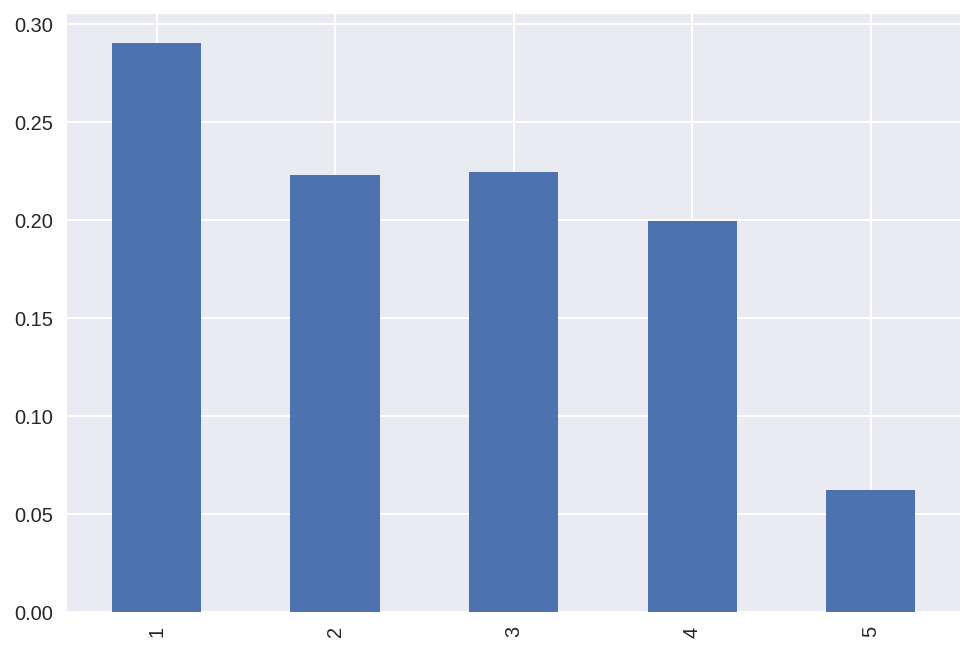

In [15]:
employment_types.groupby(['AREA_CODE', 'AREA_TYPE_CODE', 'ROME_PROFESSION_CARD_CODE'])\
    .size()\
    .value_counts(normalize=True)\
    .sort_index()\
    .plot(kind='bar');

Our hypothesis was not that bad. Only 5% of the markets have observations for the 5 employment types. Hopefully, we won't have too much of the "Other" category which does not mean a lot.

**Out of curiosity, what are the jobs that need "other" contract types?**

In [16]:
employment_types[employment_types.CONTRACT_TYPE_CODE  == 99]\
    .sort_values('NB_OFFERS', ascending = False)\
    [['AREA_NAME', 'AREA_TYPE_NAME', 'NB_OFFERS', 'OFFERS_PERCENT', 'ROME_PROFESSION_CARD_NAME']]\
    .head(10)

,AREA_NAME,AREA_TYPE_NAME,NB_OFFERS,OFFERS_PERCENT,ROME_PROFESSION_CARD_NAME
367868,FRANCE ENTIERE,France entière,18942,37.26,Relation commerciale auprès de particuliers
388555,FRANCE ENTIERE,France entière,8743,43.81,Transaction immobilière
373351,FRANCE ENTIERE,France entière,6124,24.89,Entretien des espaces verts
404937,FRANCE ENTIERE,France entière,4601,11.40,Relation commerciale grands comptes et entrepr...
393752,FRANCE ENTIERE,France entière,3712,54.15,Direction de petite ou moyenne entreprise
384237,PAYS DE LA LOIRE,Région,2951,94.98,Direction de petite ou moyenne entreprise
16424,LE MANS,Bassin,2925,98.88,Direction de petite ou moyenne entreprise
271141,SARTHE,Département,2925,98.69,Direction de petite ou moyenne entreprise
370203,PAYS DE LA LOIRE,Région,2863,71.38,Entretien des espaces verts
394145,FRANCE ENTIERE,France entière,2707,10.95,Maintenance des bâtiments et des locaux


Ok that makes sense... We can find here entrepreneurs. As internships are not in our list of contract types, we can imagine that we would find them in this category.

**Let's have a look to how many of each employment type we have.**

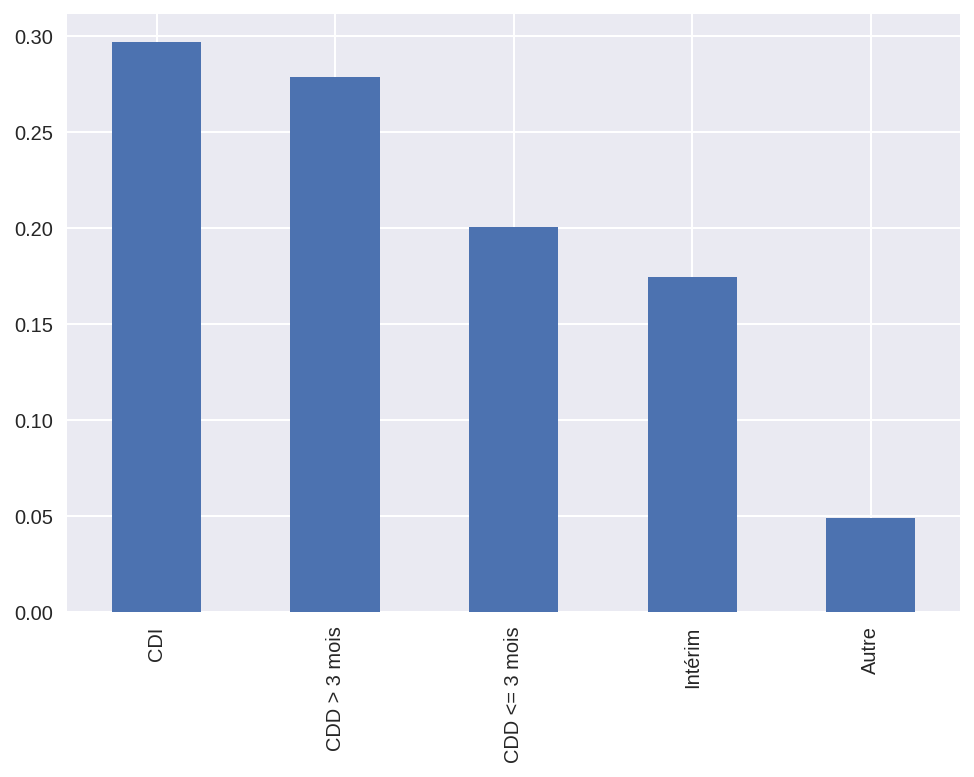

In [17]:
employment_types.CONTRACT_TYPE_NAME.value_counts(normalize=True)\
    .plot(kind='bar');

Great the not-super-useful "Other" category is in a minority. Longer duration contracts are more often observed that shorter ones. Good for the future applicants!

One of the main difference is that we have now access to the number of observations not only to the percentages.
**So it may be interesting to know what part of these observations is based on very few observations.** We focus here on the markets that have only 1 employment type observed. Why those? First, because it is easier (we are lazy). But also because, these are the ones more prone to be covered only by few observations (when you have only 1 observation it represents 100% of the cases... Quick win!).

48090

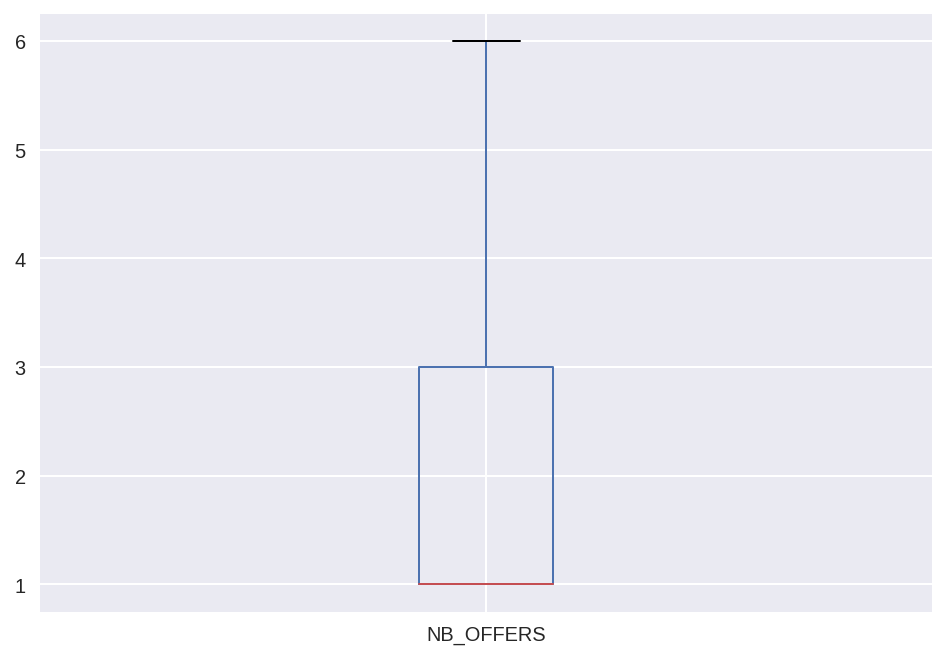

In [18]:
employment_types[employment_types.OFFERS_PERCENT == 100]\
    .NB_OFFERS.plot(kind='box', showfliers=False)
len(employment_types[employment_types.OFFERS_PERCENT == 100])

Half of the 48090 markets with 1 contract type observed 100% of the time, have only 1 offer observed for this contract. That is a lot. Thus, setting a minimum threshold of offers seems like a good idea.

BTW, before dropping those rows, let's sum all of them to see what are the global numbers for the whole country. First let's check that we have the same totals for each area type:

In [19]:
employment_types\
    .groupby(['AREA_TYPE_CODE', 'CONTRACT_TYPE_NAME']).NB_OFFERS.sum()\
    .sort_values(ascending=False)\
    .to_frame('total_offers')\
    .reset_index()\
    .pivot(index='CONTRACT_TYPE_NAME', columns='AREA_TYPE_CODE', values='total_offers')

AREA_TYPE_CODE,B,D,F,R
CONTRACT_TYPE_NAME,,,,
Autre,92209,92209,92209,92209
CDD <= 3 mois,563772,563772,563772,563772
CDD > 3 mois,783015,783015,783015,783015
CDI,1144264,1144264,1144264,1144264
Intérim,412151,412151,412151,412151


Perfect, congrats Pôle emploi, no offers got lost in the count. So now let's plot the distribution as a ratio.

,ratio_offers
CONTRACT_TYPE_NAME,
CDI,0.382006
CDD > 3 mois,0.261405
CDD <= 3 mois,0.188212
Intérim,0.137594
Autre,0.030783


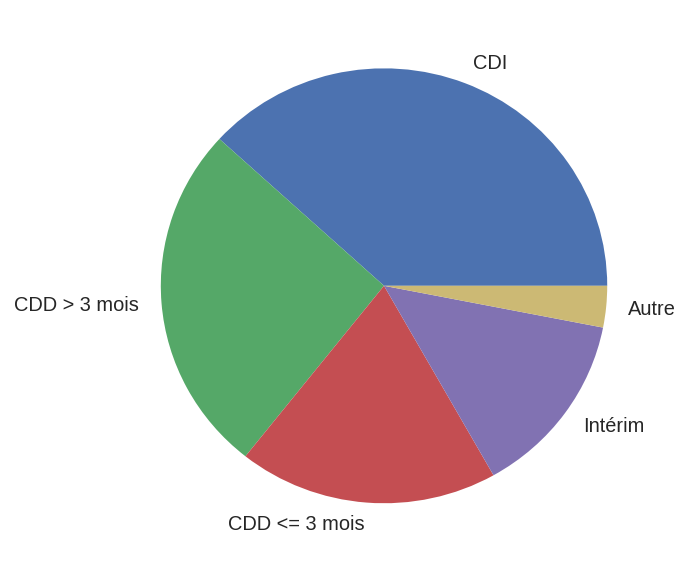

In [20]:
total_offers = employment_types[employment_types.AREA_TYPE_CODE == 'F']\
    .groupby('CONTRACT_TYPE_NAME').NB_OFFERS.sum()\
    .sort_values(ascending=False)
total_offers.plot(kind='pie', figsize=(5, 5)).axis('off')
total_offers.div(total_offers.sum()).to_frame('ratio_offers')

Wow, that's pretty cool, 38% of job offers are for long term employment, and a majority (64%) are for more than 3 months. That's a good news for jobseekers.

OK back to more precise area types… **What is the distribution of the number of offers at the bassin, department and region levels?**

Bassins:

In [21]:
employment_types[employment_types.AREA_TYPE_CODE == 'B'].NB_OFFERS.describe().to_frame()

,NB_OFFERS
count,268770.000000
mean,11.144886
std,43.436658
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,6141.000000


Departments:

In [22]:
employment_types[employment_types.AREA_TYPE_CODE == 'D'].NB_OFFERS.describe().to_frame()

,NB_OFFERS
count,117806.000000
mean,25.426642
std,91.445260
min,1.000000
25%,2.000000
50%,5.000000
75%,18.000000
max,6846.000000


Regions:

In [23]:
employment_types[employment_types.AREA_TYPE_CODE == 'R'].NB_OFFERS.describe().to_frame()

,NB_OFFERS
count,28177.000000
mean,106.306952
std,364.240528
min,1.000000
25%,3.000000
50%,13.000000
75%,61.000000
max,11512.000000


Overall, there aren't that much observations for each contract type x area x job group. At the department and Bassin levels, most of the jobs has less than 20 offers in the area. Thus let's stay cautious when considering those data.

**Let's not focus on a specific contract type and look at the number of offers for each job groups.**
First the regions:

In [24]:
offers_sum = employment_types.groupby(['AREA_CODE', 'AREA_TYPE_CODE', 'ROME_PROFESSION_CARD_CODE'])\
    .NB_OFFERS.sum()\
    .to_frame('total_offers')\
    .reset_index()
offers_sum[offers_sum.AREA_TYPE_CODE == 'R'].describe()

,total_offers
count,8170.000000
mean,366.635373
std,1011.461364
min,1.000000
25%,9.000000
50%,52.000000
75%,246.000000
max,17450.000000


Departments:

In [25]:
offers_sum[offers_sum.AREA_TYPE_CODE == 'D'].describe()

,total_offers
count,41262.000000
mean,72.594906
std,214.831126
min,1.000000
25%,4.000000
50%,14.000000
75%,55.000000
max,8322.000000


And, Bassins:

In [26]:
offers_sum[offers_sum.AREA_TYPE_CODE == 'B'].describe()

,total_offers
count,115613.000000
mean,25.908946
std,87.729175
min,1.000000
25%,2.000000
50%,6.000000
75%,19.000000
max,6323.000000


At the department level, most of the job groups have between 55 and 4 total offers (with information on contract types). This is a little bit more than twice what we saw when considering each contract type individually. Still, it is not huge.

**Let's investigate how much data we would lost if using a threshold on the total number of offers.** Let's focus on department, as it is the granularity level we are actually using in Bob.

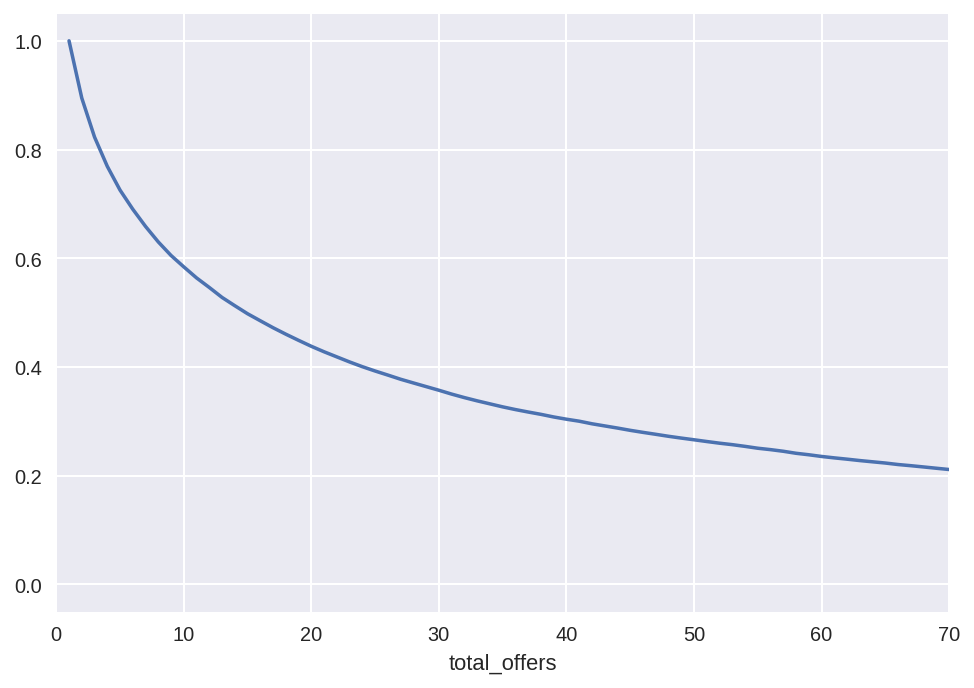

In [27]:
department_offers_sum = offers_sum[offers_sum.AREA_TYPE_CODE == 'D']
department_offers_sum.sort_values('total_offers', ascending=False)\
    .reset_index(drop=True).reset_index().drop_duplicates('total_offers', keep='last')\
    .sort_values('total_offers')\
    .set_index('total_offers')['index'].div(len(department_offers_sum))\
    .plot(xlim=(0, 70));

We'll lost almost 25% of the data with a threshold at 5 but we'll still have 50% of the data for departments with a threshold at 15.

We've seen that most of the time, employers can propose more than one contract type for a market.
**Can we find if some contract types are more often used alone or in combination (and which combinations)?**

In [28]:
job_contracts = employment_types\
    .sort_values('CONTRACT_TYPE_NAME')\
    .groupby(['AREA_CODE', 'AREA_TYPE_CODE', 'ROME_PROFESSION_CARD_CODE'])\
    .CONTRACT_TYPE_NAME.apply(lambda t: ', '.join(t))
job_contracts.value_counts().div(len(job_contracts)).to_frame().head()

,CONTRACT_TYPE_NAME
"CDD <= 3 mois, CDD > 3 mois, CDI, Intérim",0.171474
CDI,0.124384
"CDD <= 3 mois, CDD > 3 mois, CDI",0.112939
"CDD > 3 mois, CDI",0.089959
CDD > 3 mois,0.085344


For 17% of the job groups, employers propose only the classical contract types. Offering only a long-term contract (CDI) is also quite common (12%). This is good news for Bob users as they mostly look for [these type of contracts](https://github.com/bayesimpact/bob-emploi-internal/blob/master/data_analysis/notebooks/bob_emploi_usage/contract_types.ipynb).

However, [previous work](https://github.com/bayesimpact/bob-emploi-internal/blob/master/data_analysis/notebooks/research/contract_types/contract_recommendations.ipynb) done on how this data could trigger specific recommendations, suggests that user would benefit from looking also for long CDDs. As seen on the barplot above, long CDDs have been proposed almost 28% of the time.

**Let's now compare scraped with API-retrieved data. What about 'Extraction solide' in the Alpes-Maritimes department?**

In [29]:
employment_types[(employment_types.AREA_CODE=='06') & (employment_types.ROME_PROFESSION_CARD_CODE == 'F1402')]\
    [['AREA_NAME', 'CONTRACT_TYPE_NAME', 'NB_OFFERS', 'OFFERS_PERCENT', 'ROME_PROFESSION_CARD_NAME']]

,AREA_NAME,CONTRACT_TYPE_NAME,NB_OFFERS,OFFERS_PERCENT,ROME_PROFESSION_CARD_NAME
345892,ALPES-MARITIMES,Intérim,1,100.0,Extraction solide


Yihii! On the 26th of Sep 2017, the [website](http://candidat.pole-emploi.fr/marche-du-travail/statistiques?codeMetier=15020&codeZoneGeographique=06&typeZoneGeographique=DEPARTEMENT) displays the same info. Note that this is different from the [scraped data observations](https://github.com/bayesimpact/bob-emploi-internal/blob/master/data_analysis/notebooks/research/contract_types/contract_recommendations.ipynb) where CDDs, Interim and CDI offers could be found for this job.

## Conclusion

For a selected use case, we have a perfect consistancy between API retrived data and data from the website.
Overall only a low/medium number of offers have been observed per job groups.
Most of the time, employers propose the four main contract types (CDI, CDDs and Interim). However, CDI (long term contracts) are also quite commonly proposed alone (12%).


# General Conclusion

- This dataset is ready to be used. 
- In addition to contract type percentages per job group and area, it also provides raw offers number. That could be useful to discard non informative data.
- Moreover, we have now access to multiple granularity layer for areas.

Next steps:
- The multiple granularities lead to the question of the stability of these observation across different levels (e.g between the department and the "Bassin" levels).
- It could be interesting to measure the changes between this updated dataset and the scraped data.
- These data could be used to update the [contract recommandations](https://github.com/bayesimpact/bob-emploi-internal/blob/master/data_analysis/notebooks/research/contract_types/contract_recommendations.ipynb) computed on the scraped data.
- Finally, we definitely need to explore the contract type usage per department and per job.